In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple, defaultdict, Counter

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
Tag = namedtuple("Tag", ["token", "tag"])
BEGIN_TAG = Tag("^", "<BOS>")
END_TAG = Tag("$", "<EOS>")

def load_sequences(filename, sep="\t", notypes=False, to_chars=False):
    sequences = []
    prev_char_tag = "O"
    with open(filename) as fp:
        seq = []
        if to_chars:
            seq = [BEGIN_TAG]
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if notypes:
                    line[1] = line[1][0]
                if not to_chars:
                    seq.append(Tag(*line))
                else:
                    if line[1] == "O":
                        # Take care of outside blocks
                        t = "O"
                        for l in line[0]:
                            seq.append(Tag(l, t))
                    # Take care of phrase blocks
                    elif len(line[0]) == 1 and line[1][0] == "U":
                        t = "U%s" % line[1][1:]
                        seq.append(Tag(l, t))
                    else:
                        if line[1][0] in ["B", "U"]:
                            # start with B
                            t = "%s%s" % ("B", line[1][1:])
                        else:
                            # continue with inside
                            t = "%s%s" % ("I", line[1][1:])
                        seq.append(Tag(line[0][0], t))
                        for l in line[0][1:-1]:
                            t = "%s%s" % ("I", line[1][1:])
                            seq.append(Tag(l, t))
                        if line[1][0] in ["U", "E"]:
                            t = "%s%s" % ("E", line[1][1:])
                            seq.append(Tag(line[0][-1], t))
                        else:
                            t = "%s%s" % ("I", line[1][1:])
                            seq.append(Tag(line[0][-1], t))
                    if t[0] in ["B", "I"]:
                        t = "%s%s" % ("I", line[1][1:])
                        seq.append(Tag(" ", t))
                    else:
                        t = "O"
                        seq.append(Tag(" ", t))
            else:
                if to_chars:
                    seq.append(END_TAG)
                sequences.append(seq)
                seq = []
                if to_chars:
                    seq = [BEGIN_TAG]
        if seq:
            if to_chars:
                seq.append(END_TAG)
            sequences.append(seq)
    return sequences
    

In [4]:
train = load_sequences("data/cleaned/train.BIEOU.tsv", to_chars=True, notypes=True)
test = load_sequences("data/cleaned/dev.BIEOU.tsv", to_chars=True, notypes=True)

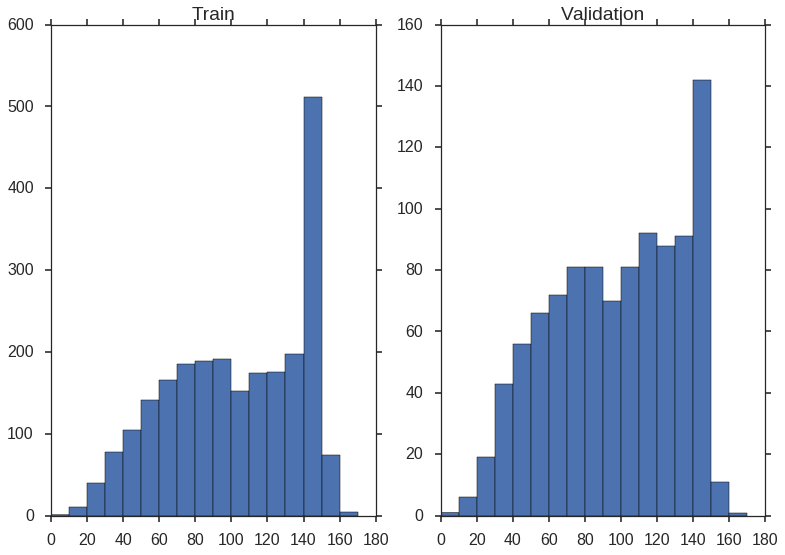

In [5]:
fig, ax = plt.subplots(1,2)
ax[0].hist([len(seq) for seq in train], bins=range(0,180,10))
ax[1].hist([len(seq) for seq in test], bins=range(0,180,10))
ax[0].set_title("Train")
ax[1].set_title("Validation")

In [6]:
labels = sorted(Counter(t.tag for seq in train for t in seq).keys(), key=lambda x: x.split("-")[-1])
labels

['<BOS>', '<EOS>', 'B', 'E', 'I', 'O']

In [7]:
labels = ["MASK"] + labels
label2id = {l: i for i, l in enumerate(labels)}
label2id

{'<BOS>': 1, '<EOS>': 2, 'B': 3, 'E': 4, 'I': 5, 'MASK': 0, 'O': 6}

## Modeling

In [43]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, TimeDistributed, Merge, merge
from keras.callbacks import TensorBoard, ModelCheckpoint

In [9]:
CHAR_INPUT_DIM=127 + 1
CHAR_EMBED=50
MAXLENGTH=150
NUM_LABELS=len(label2id)

In [10]:
X_train = sequence.pad_sequences([[ord(t.token) for t in seq] for seq in train], maxlen=MAXLENGTH)
X_test = sequence.pad_sequences([[ord(t.token) for t in seq] for seq in test], maxlen=MAXLENGTH)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

('X_train shape:', (2395, 150))
('X_test shape:', (1001, 150))


In [11]:
Y_train = sequence.pad_sequences([[label2id[t.tag] for t in seq] for seq in train], maxlen=MAXLENGTH)
Y_test = sequence.pad_sequences([[label2id[t.tag] for t in seq] for seq in test], maxlen=MAXLENGTH)

train_sample_weight = Y_train != 0
test_sample_weight = Y_test != 0

Y_train = np.expand_dims(Y_train, -1)
Y_test = np.expand_dims(Y_test, -1)


print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)

print('train_sample_weight shape:', train_sample_weight.shape)
print('test_sample_weight shape:', test_sample_weight.shape)

('y_train shape:', (2395, 150, 1))
('y_test shape:', (1001, 150, 1))
('train_sample_weight shape:', (2395, 150))
('test_sample_weight shape:', (1001, 150))


In [41]:
num_layers=3
lstm_units=32

input_layer = Input(shape=(MAXLENGTH,), dtype='int32')
emb = Embedding(input_dim=CHAR_INPUT_DIM, output_dim=CHAR_EMBED,
                           input_length=MAXLENGTH, mask_zero=True)(input_layer)
# apply forwards LSTM
forward_lstms = []
prev_layer = emb
for i in xrange(num_layers):
    fw_lstm = LSTM(lstm_units, return_sequences=True)(prev_layer)
    prev_layer = fw_lstm
    forward_lstms.append(fw_lstm)

# apply backwards LSTM
backward_lstms = []
prev_layer = emb
for i in xrange(num_layers):
    bw_lstm = LSTM(lstm_units, return_sequences=True, go_backwards=True)(prev_layer)
    prev_layer = bw_lstm
    backward_lstms.append(bw_lstm)

merged_layer = merge([fw_lstm, bw_lstm], mode="concat")
dropout = Dropout(p=0.5)(merged_layer)
dense = TimeDistributed(Dense(128, activation='tanh'))(dropout)
out = TimeDistributed(Dense(NUM_LABELS, activation='softmax'))(dense)

In [44]:
model = Model(input=input_layer, output=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode="temporal",  metrics=['accuracy'])
tb_callback = TensorBoard(log_dir='./tb_logs', histogram_freq=0, write_graph=True)
mc_callback = ModelCheckpoint("models/LSTM3.hdf5", monitor='val_loss', save_best_only=True)

In [ ]:
model.fit(X_train, Y_train, nb_epoch=50,
          sample_weight=train_sample_weight,
         validation_data=(X_test, Y_test, test_sample_weight),
         callbacks=[tb_callback, mc_callback])

In [46]:
model.history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

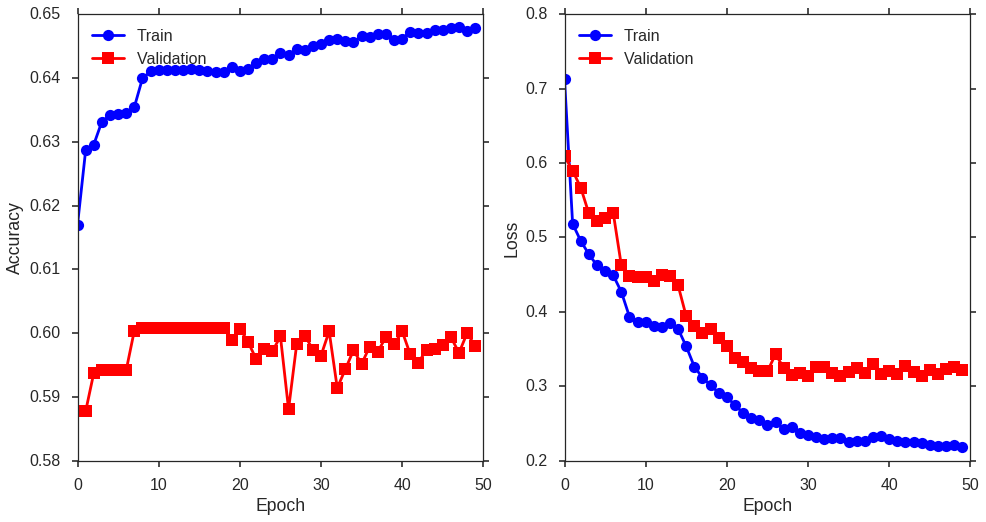

In [47]:
fig, ax = plt.subplots(1,2 ,figsize=(16,8))


ax[0].plot(model.history.epoch, model.history.history["acc"], "-bo", label="Train")
ax[0].plot(model.history.epoch, model.history.history["val_acc"], "-rs", label="Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="upper left")

ax[1].plot(model.history.epoch, model.history.history["loss"], "-bo", label="Train")
ax[1].plot(model.history.epoch, model.history.history["val_loss"], "-rs", label="Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper left")

In [48]:
predictions = model.predict(X_train)

In [49]:
predictions.argmax(axis=-1)[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 2])

In [50]:
Y_train[1].flatten()

array([0, 0, 0, 0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 2], dtype=int32)

In [51]:
predictions.argmax(axis=-1)[1] == Y_train[1].flatten()

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [52]:
predictions_val = model.predict(X_test)

In [53]:
predictions_val.argmax(axis=-1)[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2])

In [54]:
Y_test[0].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2], dtype=int32)

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
confusion_matrix(Y_train.flatten(),
                            predictions.argmax(axis=-1).flatten(),
                labels=range(len(labels)))

array([[     0, 111872,    196,      0,      0,      0,   2342],
       [     0,   2330,      0,      0,      0,      0,      0],
       [     0,      0,   2394,      0,      0,      0,      1],
       [     0,      0,      0,    436,      0,     12,   1049],
       [     0,      0,      0,      0,      0,    754,    734],
       [     0,      0,      0,     27,      0,   5126,   6135],
       [     0,      0,     21,    241,      0,   2105, 223475]])

In [74]:
confusion_matrix(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)))

array([[  2330,      0,      0,      0,      0,      0],
       [     0,   2394,      0,      0,      0,      1],
       [     0,      0,    436,      0,     12,   1049],
       [     0,      0,      0,      0,    754,    734],
       [     0,      0,     27,      0,   5126,   6135],
       [     0,     21,    241,      0,   2105, 223475]])

In [77]:
print classification_report(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)), target_names=labels[1:])

             precision    recall  f1-score   support

      <BOS>       1.00      1.00      1.00      2330
      <EOS>       0.99      1.00      1.00      2395
          B       0.62      0.29      0.40      1497
          E       0.00      0.00      0.00      1488
          I       0.64      0.45      0.53     11288
          O       0.97      0.99      0.98    225842

avg / total       0.94      0.95      0.95    244840



In [78]:
df_cfr = confusion_matrix(Y_train.flatten()[Y_train.flatten() != 0],
                            predictions.argmax(axis=-1).flatten()[Y_train.flatten() != 0],
                labels=range(1,len(labels)))

df_cfr = pd.DataFrame(df_cfr, index=labels[1:], columns=labels[1:])
df_cfr

,<BOS>,<EOS>,B,E,I,O
<BOS>,2330,0,0,0,0,0
<EOS>,0,2394,0,0,0,1
B,0,0,436,0,12,1049
E,0,0,0,0,754,734
I,0,0,27,0,5126,6135
O,0,21,241,0,2105,223475


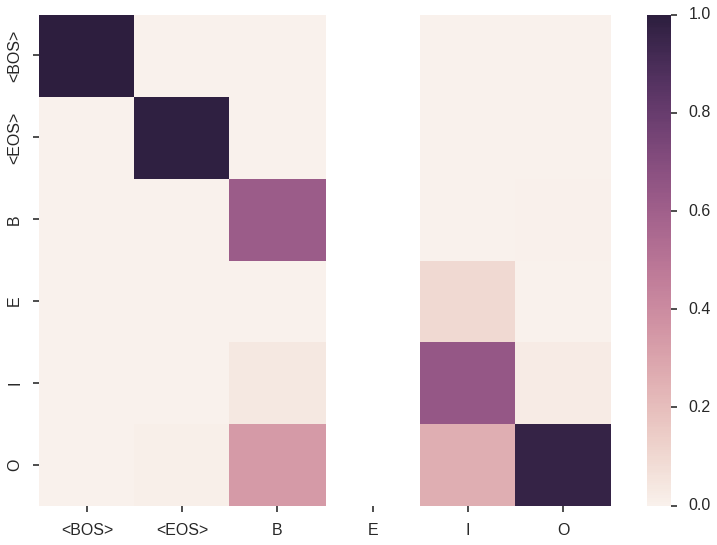

In [80]:
sns.heatmap(df_cfr.divide(df_cfr.sum()))

In [81]:
df_cfr = confusion_matrix(Y_test.flatten()[Y_test.flatten() != 0],
                            predictions_val.argmax(axis=-1).flatten()[Y_test.flatten() != 0],
                labels=range(1,len(labels)))

df_cfr = pd.DataFrame(df_cfr, index=labels[1:], columns=labels[1:])
df_cfr

,<BOS>,<EOS>,B,E,I,O
<BOS>,991,0,0,0,0,0
<EOS>,0,1001,0,0,0,0
B,0,0,134,0,15,515
E,0,0,0,0,268,386
I,0,0,10,0,1750,3598
O,0,11,175,0,2168,85894


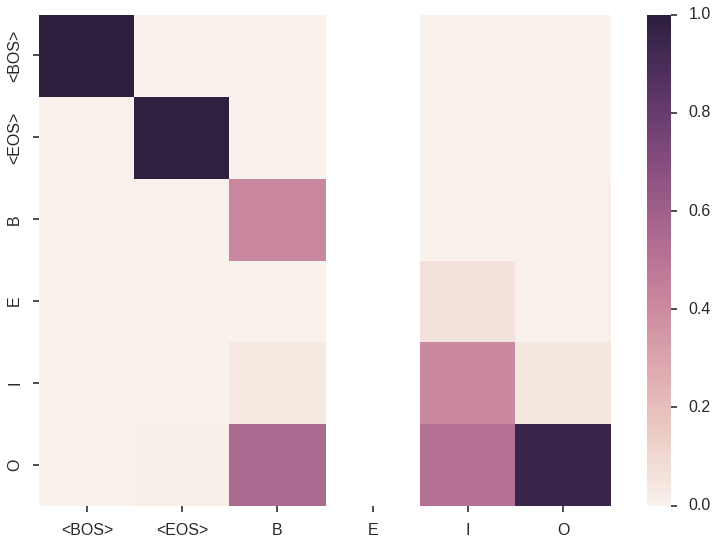

In [82]:
sns.heatmap(df_cfr.divide(df_cfr.sum()))

In [86]:
df_cfr.sum(axis=1)

<BOS>      991
<EOS>     1001
B          664
E          654
I         5358
O        88248
dtype: int64

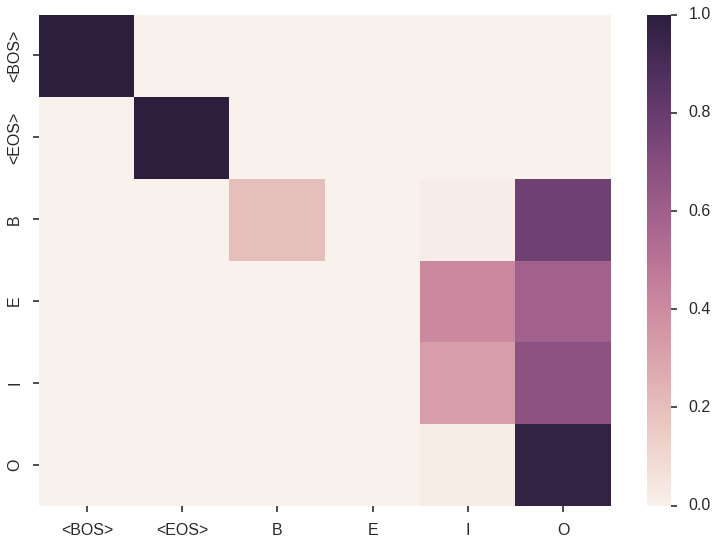

In [92]:
sns.heatmap(df_cfr.divide(df_cfr.sum(axis=1), axis=0))

In [115]:
def write_predictions(data, y_true, y_pred, labels, filename):
    with open(filename, "wb+") as fp:
        for i, seq in enumerate(data):
            y = y_pred[i, (y_true[i, :]!= 0).flatten()]
            for t, pred in zip(seq, y):
                print_line = "%s\t%s\t%s" % (t.token, t.tag, labels[pred])
                if t.token == " ":
                    print_line = "%s\t%s\t%s" % ("<space>", t.tag, labels[pred])
                print >> fp, print_line


In [117]:
write_predictions(test, Y_test, predictions_val.argmax(axis=-1), labels, "dev_notypes.char.tsv")